實測Garmin inReach Mini2 GPS數值比較  
===============
---------------
* Version: V1.0
* Date: 2022/12/09
* Author: KTChen
---------------
# 前言
## 緣由
想知道Garmin inReach Mini2 不含氣壓計的GPS data是否會有飄移的現象

## 測試環境
* 地點: 雪山主東線
* 時間: 2022/12/03
* 氧氣: 無氧
* 設備: 
    * inReach Mini 2
        - 訂閱方案:Freedom Safety Plan
        - 位置追蹤時間區隔: 10分鐘 (很貴)
        - 掛在右肩帶


    * Garmin fenix 7x sapphire solar
        - 登山活動 衛星設定: 預設值: 自動選擇
        - 戴在左手
        - 出發前沒有手動校正高度

## 測試步驟
* inReach全程開啟, 10分鐘傳送一個追蹤點
* Fenix大休息的時候會按暫停

## 分析步驟
1. 取出點位
    1. 從Garmin Explore網站匯出含追蹤點之GPX (點位數:68)
    1. 自inReach 取出原始Fit檔 (點位數:4370)
    1. Fenix 取出原始Fit檔 (點位數:35127)


1. 取得點位對應的DTM高度
    1. 內政部20公尺網格DTM資料為基礎
    1. 使用 https://outdoorsafetylab.org/elevation_api 所提供的Open source docker自行架設API 查詢


1. 比對點位資料之差異
    1. 比較inReach點位, GPS高度與DTM高度
    1. 比較inReach與Fenix高度
    1. 比較經緯度
    1. 綜合疊圖



# 讀取點位資料
## 讀取Explore匯出之GPX檔

In [1]:
%matplotlib inline
import gpxpy
import gpxpy.gpx
import pandas as pd

with open ('explore.gpx') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

records_ex = []
for point in gpx.tracks[0].segments[0].points:
    records_ex.append({
        "timestamp":point.time,
        "lat":point.latitude,
        "lon":point.longitude,
        "alt":point.elevation})

點位總數

In [2]:
len(records_ex)

68

讀取前三筆資料

In [3]:
records_ex[:3]

[{'timestamp': datetime.datetime(2022, 12, 2, 18, 9, tzinfo=SimpleTZ("Z")),
  'lat': 24.386065,
  'lon': 121.298675,
  'alt': 2160.0},
 {'timestamp': datetime.datetime(2022, 12, 2, 18, 9, tzinfo=SimpleTZ("Z")),
  'lat': 24.385871,
  'lon': 121.298761,
  'alt': 2154.14},
 {'timestamp': datetime.datetime(2022, 12, 2, 18, 19, tzinfo=SimpleTZ("Z")),
  'lat': 24.385293,
  'lon': 121.296765,
  'alt': 2234.03}]

## 讀取從inReachMini2提取之fit檔

In [4]:
from garmin_fit_sdk import Decoder, Stream, Profile
stream_in = Stream.from_file("inReachMini2.fit")
decoder_in = Decoder(stream_in)

records_in = []

def filter_data(message):
    r = {};
    r["timestamp"] = message["timestamp"]
    #lat, lon need to divide 11930465 (2^32 / 360) to get decimal degrees
    r["lat"] = message["position_lat"] / 11930465
    r["lon"] = message["position_long"] / 11930465
    r["alt"] = message["enhanced_altitude"]
    return r

def mesg_listener_in(mesg_num, message):
    if mesg_num == 20: #'20': 'record'
        if {"position_lat", "position_long","enhanced_altitude"} <= message.keys(): #multiple keys are in the dictionary
            records_in.append(filter_data(message))

messages, errors = decoder_in.read(convert_datetimes_to_dates = True, mesg_listener = mesg_listener_in)

In [5]:
len(records_in)

4370

讀取前三筆資料

In [6]:
records_in[:3]

[{'timestamp': datetime.datetime(2022, 12, 2, 18, 9, 15, tzinfo=datetime.timezone.utc),
  'lat': 24.385876577316978,
  'lon': 121.29876396267873,
  'alt': 2154.6},
 {'timestamp': datetime.datetime(2022, 12, 2, 18, 9, 20, tzinfo=datetime.timezone.utc),
  'lat': 24.385929634762768,
  'lon': 121.29875591605189,
  'alt': 2149.4},
 {'timestamp': datetime.datetime(2022, 12, 2, 18, 9, 24, tzinfo=datetime.timezone.utc),
  'lat': 24.385975399952976,
  'lon': 121.29875382057615,
  'alt': 2151.4}]

# 讀取點位的DEM值 ##
在這邊使用的是https://outdoorsafetylab.org/elevation_api 所提供的Open source docker自行架設API 查詢<br>
以內政部20公尺網格DTM資料為基礎
>由於這個docker file 不能跑在目前跑jupyter的Arm server上 <br>
>因此在另一個VM架設API server 並查詢, 此過程略過 <br>
>得到的點位另存為explore_dem.txt & inreach_dem.txt <br>


In [7]:
import ast
with open("explore_dem.txt", "r") as f:
    dtm_ex = ast.literal_eval(f.read())
    
with open("inreach_dem.txt", "r") as f:
    dtm_in = ast.literal_eval(f.read())

In [8]:
dtm_ex[:3]

[2151.300048828125, 2153.02001953125, 2258.090087890625]

In [9]:
dtm_in[:3]

[2153.02001953125, 2153.02001953125, 2153.02001953125]

整合資料準備畫圖

In [10]:
df_ex = pd.DataFrame(records_ex)
df_in = pd.DataFrame(records_in)

df_ex['dtm']=dtm_ex
df_in['dtm']=dtm_in

df_ex['timestamp'] = df_ex['timestamp'].dt.tz_localize(None)
df_in['timestamp'] = df_in['timestamp'].dt.tz_localize(None)

Explore GPX

In [11]:
df_ex

timestamp        lat         lon      alt          dtm
0  2022-12-02 18:09:00  24.386065  121.298675  2160.00  2151.300049
1  2022-12-02 18:09:00  24.385871  121.298761  2154.14  2153.020020
2  2022-12-02 18:19:00  24.385293  121.296765  2234.03  2258.090088
3  2022-12-02 18:29:00  24.385293  121.295006  2339.37  2362.649902
4  2022-12-02 18:39:00  24.385303  121.290821  2361.19  2430.780029
..                 ...        ...         ...      ...          ...
63 2022-12-03 04:59:00  24.385206  121.292366  2407.80  2402.209961
64 2022-12-03 05:09:00  24.385550  121.295971  2317.62  2306.540039
65 2022-12-03 05:14:00  24.385388  121.296851  2262.00  2244.169922
66 2022-12-03 05:19:00  24.385711  121.297795  2207.29  2199.820068
67 2022-12-03 05:23:45  24.385850  121.298868  2162.09  2149.379883

[68 rows x 5 columns]

inReach Activity

In [12]:
df_in

timestamp        lat         lon     alt          dtm
0    2022-12-02 18:09:15  24.385877  121.298764  2154.6  2153.020020
1    2022-12-02 18:09:20  24.385930  121.298756  2149.4  2153.020020
2    2022-12-02 18:09:24  24.385975  121.298754  2151.4  2153.020020
3    2022-12-02 18:09:33  24.386053  121.298752  2157.0  2151.300049
4    2022-12-02 18:09:43  24.386070  121.298706  2160.2  2151.300049
...                  ...        ...         ...     ...          ...
4365 2022-12-03 05:23:21  24.386081  121.298778  2161.8  2151.300049
4366 2022-12-03 05:23:30  24.386025  121.298831  2160.6  2147.350098
4367 2022-12-03 05:23:42  24.385910  121.298849  2160.4  2147.350098
4368 2022-12-03 05:23:50  24.385878  121.298853  2161.0  2147.350098
4369 2022-12-03 05:24:00  24.385861  121.298860  2161.0  2149.379883

[4370 rows x 5 columns]

# 比較InReach GPS得到的高度及DTM的差距
因為我的是10分鐘回傳一次的點位的方案, 數據量不大  
因此加上inReach的Activity的資料一起比較

## 圖1 回傳Explore的Track點位

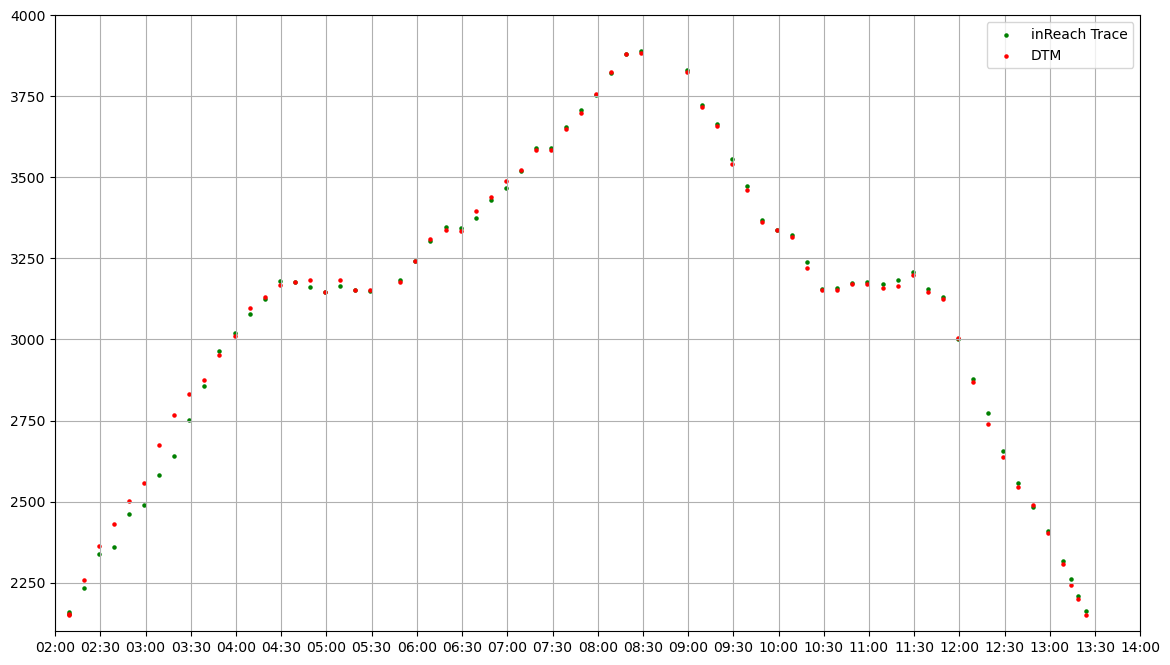

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import numpy as np

plt.rcParams['timezone'] = 'Asia/Taipei'
plt.rcParams['figure.figsize'] = [14, 8]

plt.gca().set_xlim([datetime.datetime(2022, 12, 2, 18, 0, 0), datetime.datetime(2022, 12, 3, 6, 0, 0)])
plt.gca().set_ylim(2100,4000)
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.scatter(df_ex.timestamp, df_ex.alt, color='green' , s=5, label="inReach Trace")
plt.scatter(df_ex.timestamp, df_ex.dtm, color='red' , s=5, label="DTM")

plt.grid()
plt.legend()
plt.show()

## 圖2 存在inReach 的Activity點位

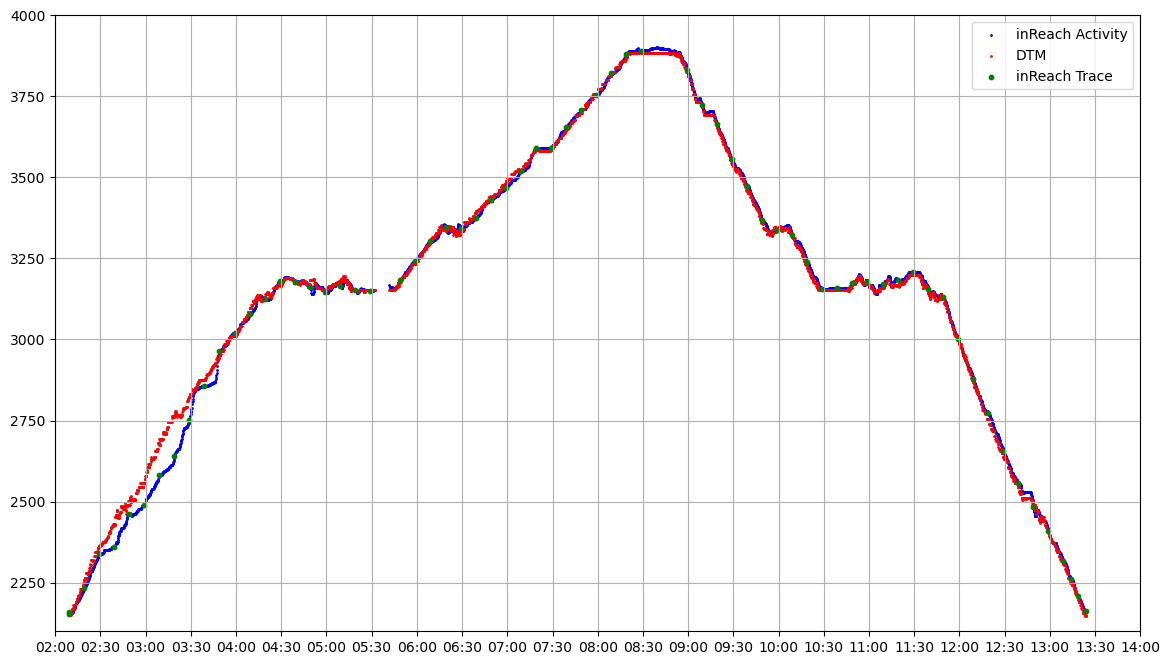

In [14]:
plt.gca().set_xlim([datetime.datetime(2022, 12, 2, 18, 0, 0), datetime.datetime(2022, 12, 3, 6, 0, 0)])
plt.gca().set_ylim(2100,4000)
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.scatter(df_in.timestamp, df_in.alt, color='blue', s=1, label="inReach Activity")
plt.scatter(df_in.timestamp, df_in.dtm, color='red' , s=1, label="DTM")
plt.scatter(df_ex.timestamp, df_ex.alt, color='green' , s=10, label="inReach Trace")

plt.grid()
plt.legend()
plt.show()

## 放大登頂區間

上面可以觀察到2:30~4:00這一點差比較多, 大約是七卡到哭坡  
奇妙的是下山這一段倒是沒有差很多

由於
* 2:00 ~ 4:00 在樹林間有遮蔽
* 5:30 ~ 7:30 在黑森林

所以我們選擇在圈谷底到登頂這一段, 3000m以上 無遮蔽的環境來放大分析
* 7:30 ~ 8:30 大約是圈谷底到登頂


In [15]:
# Using pandas.DataFrame.query() to select DataFrame Rows
start_time = '2022-12-02 23:30:00'
end_time   = '2022-12-03 00:30:00'
df_ex_zoom = df_ex.query('timestamp >= @start_time and timestamp <= @end_time')
df_in_zoom = df_in.query('timestamp >= @start_time and timestamp <= @end_time')
df_in_zoom

timestamp        lat         lon     alt          dtm
2018 2022-12-02 23:30:04  24.387967  121.236351  3599.0  3589.939941
2019 2022-12-02 23:30:15  24.387922  121.236354  3598.8  3597.270020
2020 2022-12-02 23:30:25  24.387884  121.236346  3600.0  3597.270020
2021 2022-12-02 23:30:35  24.387850  121.236349  3601.4  3597.270020
2022 2022-12-02 23:30:43  24.387839  121.236341  3601.6  3597.270020
...                  ...        ...         ...     ...          ...
2317 2022-12-03 00:29:15  24.383373  121.231802  3891.4  3883.629883
2318 2022-12-03 00:29:15  24.383372  121.231802  3891.4  3883.629883
2319 2022-12-03 00:29:24  24.383365  121.231802  3890.8  3883.629883
2320 2022-12-03 00:29:36  24.383353  121.231800  3888.8  3883.629883
2321 2022-12-03 00:29:55  24.383360  121.231801  3889.6  3883.629883

[304 rows x 5 columns]

## 圖3 登頂區間回傳Explore的點位
我們把點畫大一點

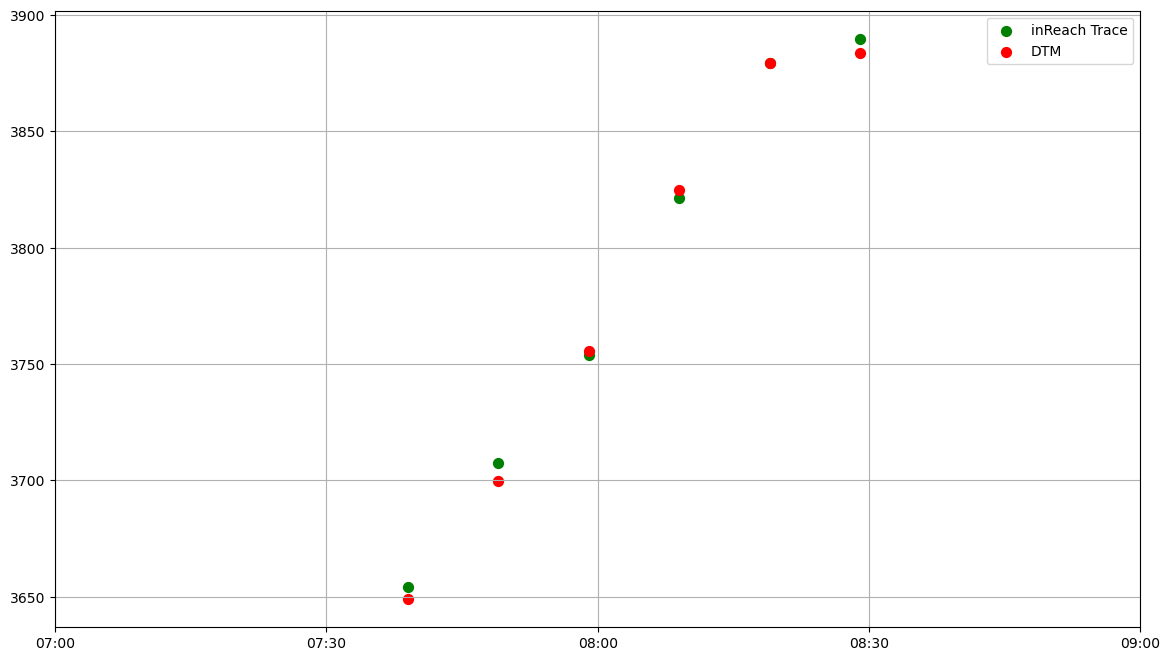

In [16]:
plt.gca().set_xlim([datetime.datetime(2022, 12, 2, 23, 0, 0), datetime.datetime(2022, 12, 3, 1, 0, 0)])
#plt.gca().set_ylim(2100,4000)
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.scatter(df_ex_zoom.timestamp, df_ex_zoom.alt, color='green', s=50, label="inReach Trace")
plt.scatter(df_ex_zoom.timestamp, df_ex_zoom.dtm, color='red' , s=50, label="DTM")

plt.grid()
plt.legend()
plt.show()

看起來好像差異很大, 用Activity的點位放大來看

## 圖4 登頂區間Activity的點位 ###

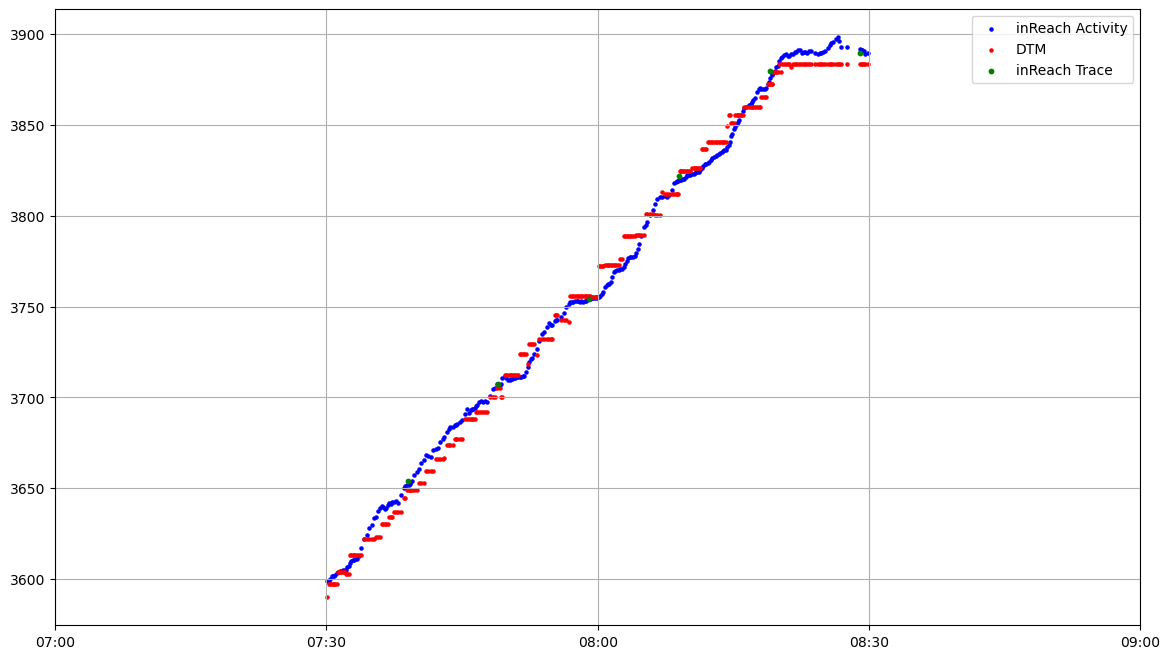

In [17]:
plt.gca().set_xlim([datetime.datetime(2022, 12, 2, 23, 0, 0), datetime.datetime(2022, 12, 3, 1, 0, 0)])
#plt.gca().set_ylim(2100,4000)
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.scatter(df_in_zoom.timestamp, df_in_zoom.alt, color='blue', s=5, label="inReach Activity")
plt.scatter(df_in_zoom.timestamp, df_in_zoom.dtm, color='red' , s=5, label="DTM")
plt.scatter(df_ex_zoom.timestamp, df_ex_zoom.alt, color='green' , s=10, label="inReach Trace")

plt.grid()
plt.legend()
plt.show()

**DTM呈現出階梯狀的高度**, 推測為20m解析度的關係, 畢竟20公尺才一個高度  
GPS點位看起來穩定上升沒有什麼誇張的上下飄移

# inReach Mini2 與 Fenix 7X GPS之比較
由於DTM資料解析度的關係, 這次和Fenix 7X 所得到的GPS資料來和inReach比較  
Fenix 7X據說是有雙頻多星, 理論上應該會更貼近真實環境  

一樣直讀 從Fenix 7X取出之Fit檔

In [18]:
from garmin_fit_sdk import Decoder, Stream, Profile
stream_fe = Stream.from_file("Fenix7X.fit")
decoder_fe = Decoder(stream_fe)

records_fe = []

def filter_data(message):
    r = {};
    r["timestamp"] = message["timestamp"]
    #lat, lon need to divide 11930465 (2^32 / 360) to get decimal degrees
    r["lat"] = message["position_lat"] / 11930465
    r["lon"] = message["position_long"] / 11930465
    r["alt"] = message["enhanced_altitude"]
    return r

def mesg_listener_in(mesg_num, message):
    if mesg_num == 20: #'20': 'record'
        if {"position_lat", "position_long","enhanced_altitude"} <= message.keys(): #multiple keys are in the dictionary
            records_fe.append(filter_data(message))

messages, errors = decoder_fe.read(convert_datetimes_to_dates = True, mesg_listener = mesg_listener_in)

df_fe = pd.DataFrame(records_fe)
df_fe['timestamp'] = df_fe['timestamp'].dt.tz_localize(None)

with open("fenix7x_dem.txt", "r") as f:
    dtm_fe = ast.literal_eval(f.read())
    
df_fe['dtm']=dtm_fe
df_fe

timestamp        lat         lon     alt          dtm
0     2022-12-02 18:08:50  24.385833  121.298828  2148.4  2149.379883
1     2022-12-02 18:08:51  24.385840  121.298827  2148.4  2149.379883
2     2022-12-02 18:08:52  24.385848  121.298824  2148.4  2149.379883
3     2022-12-02 18:08:53  24.385858  121.298821  2148.4  2149.379883
4     2022-12-02 18:08:54  24.385865  121.298819  2148.2  2147.350098
...                   ...        ...         ...     ...          ...
35122 2022-12-03 05:23:30  24.385937  121.298781  2164.8  2153.020020
35123 2022-12-03 05:23:31  24.385922  121.298783  2164.8  2153.020020
35124 2022-12-03 05:23:32  24.385904  121.298790  2164.8  2153.020020
35125 2022-12-03 05:23:33  24.385899  121.298787  2164.8  2153.020020
35126 2022-12-03 05:23:34  24.385913  121.298787  2164.8  2153.020020

[35127 rows x 5 columns]

## 圖5 inReach Mini 2 & Fenix 7X GPS比較

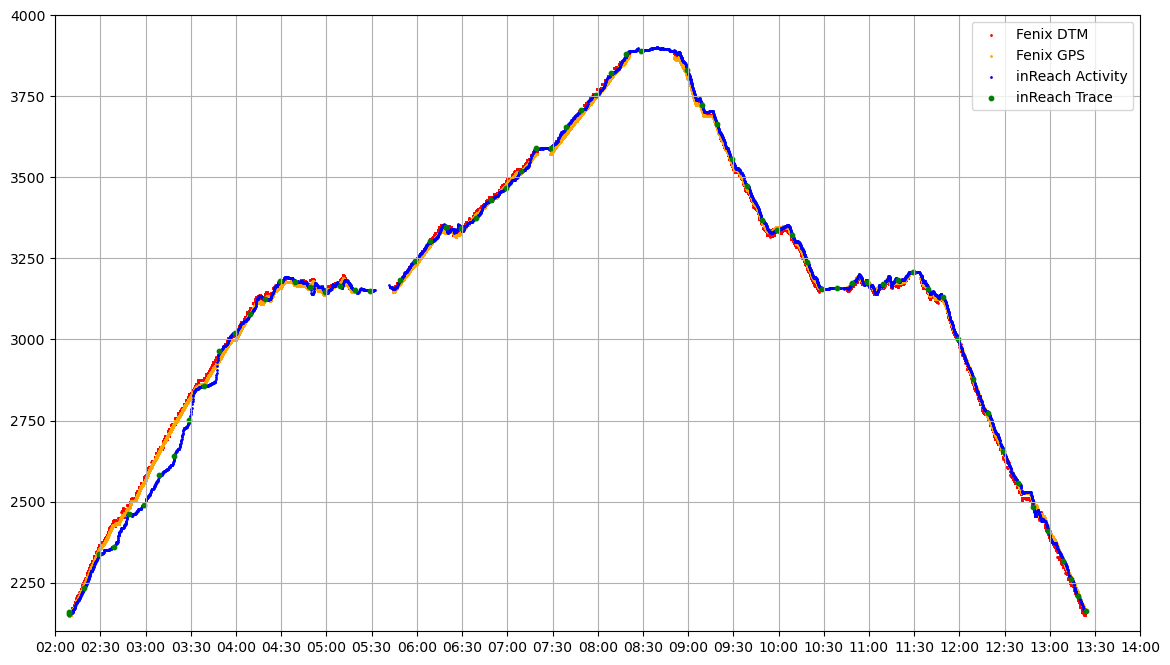

In [19]:
plt.gca().set_xlim([datetime.datetime(2022, 12, 2, 18, 0, 0), datetime.datetime(2022, 12, 3, 6, 0, 0)])
plt.gca().set_ylim(2100,4000)
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.scatter(df_fe.timestamp, df_fe.dtm, color='red' , s=1, label="Fenix DTM")
plt.scatter(df_fe.timestamp, df_fe.alt, color='orange' , s=1, label="Fenix GPS")
plt.scatter(df_in.timestamp, df_in.alt, color='blue', s=1, label="inReach Activity")
plt.scatter(df_ex.timestamp, df_ex.alt, color='green' , s=10, label="inReach Trace")

plt.grid()
plt.legend()
plt.show()

## 圖6 登頂區間 inReach Mini 2 & Fenix 7X GPS比較 
這邊把Fenix GPS所轉換的DTM資料一併比較

In [20]:
df_fe_zoom = df_fe.query('timestamp >= @start_time and timestamp <= @end_time')
df_fe_zoom

timestamp        lat         lon     alt          dtm
17203 2022-12-02 23:30:00  24.387907  121.236328  3581.0  3597.270020
17204 2022-12-02 23:30:01  24.387904  121.236323  3581.2  3597.270020
17205 2022-12-02 23:30:02  24.387902  121.236320  3581.2  3597.270020
17206 2022-12-02 23:30:03  24.387897  121.236317  3581.4  3597.270020
17207 2022-12-02 23:30:04  24.387891  121.236313  3581.6  3597.270020
...                   ...        ...         ...     ...          ...
20262 2022-12-03 00:20:59  24.383400  121.231770  3874.2  3883.629883
20263 2022-12-03 00:21:00  24.383403  121.231767  3874.2  3881.840088
20264 2022-12-03 00:21:01  24.383405  121.231765  3874.2  3881.840088
20265 2022-12-03 00:21:02  24.383405  121.231765  3874.4  3881.840088
20266 2022-12-03 00:21:03  24.383405  121.231765  3874.4  3881.840088

[3064 rows x 5 columns]

In [21]:
df_in_zoom

timestamp        lat         lon     alt          dtm
2018 2022-12-02 23:30:04  24.387967  121.236351  3599.0  3589.939941
2019 2022-12-02 23:30:15  24.387922  121.236354  3598.8  3597.270020
2020 2022-12-02 23:30:25  24.387884  121.236346  3600.0  3597.270020
2021 2022-12-02 23:30:35  24.387850  121.236349  3601.4  3597.270020
2022 2022-12-02 23:30:43  24.387839  121.236341  3601.6  3597.270020
...                  ...        ...         ...     ...          ...
2317 2022-12-03 00:29:15  24.383373  121.231802  3891.4  3883.629883
2318 2022-12-03 00:29:15  24.383372  121.231802  3891.4  3883.629883
2319 2022-12-03 00:29:24  24.383365  121.231802  3890.8  3883.629883
2320 2022-12-03 00:29:36  24.383353  121.231800  3888.8  3883.629883
2321 2022-12-03 00:29:55  24.383360  121.231801  3889.6  3883.629883

[304 rows x 5 columns]

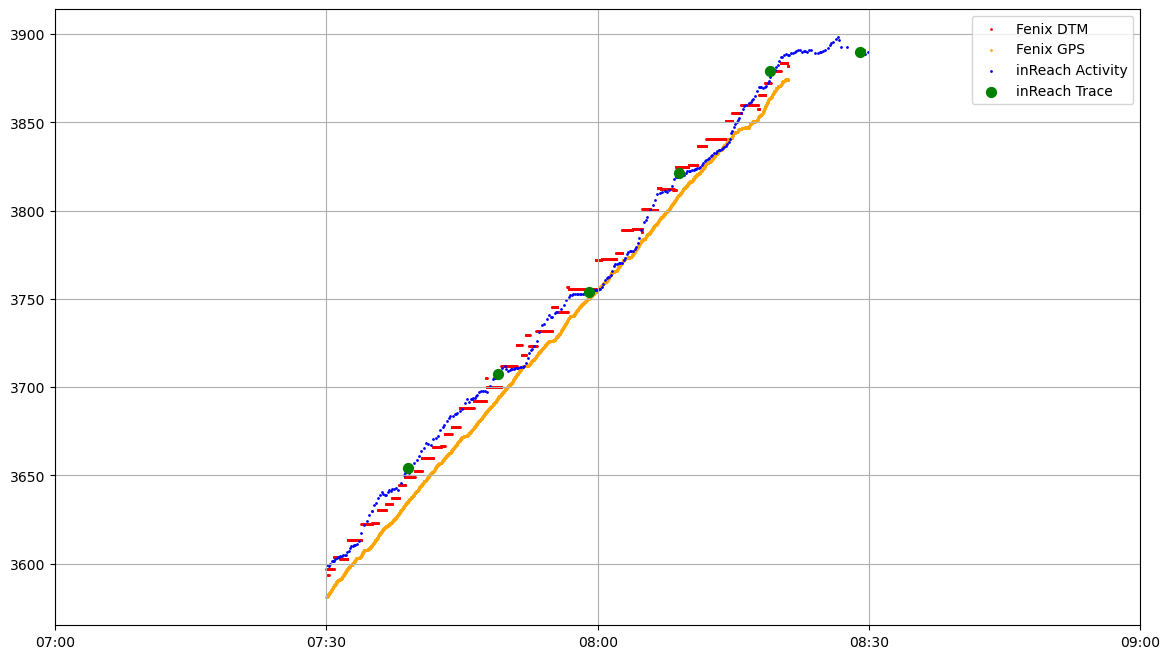

In [22]:
plt.gca().set_xlim([datetime.datetime(2022, 12, 2, 23, 0, 0), datetime.datetime(2022, 12, 3, 1, 0, 0)])
#plt.gca().set_ylim(2100,4000)
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.scatter(df_fe_zoom.timestamp, df_fe_zoom.dtm, color='red' , s=1, label="Fenix DTM")
plt.scatter(df_fe_zoom.timestamp, df_fe_zoom.alt, color='orange' , s=1, label="Fenix GPS")
plt.scatter(df_in_zoom.timestamp, df_in_zoom.alt, color='blue', s=1, label="inReach Activity")
plt.scatter(df_ex_zoom.timestamp, df_ex_zoom.alt, color='green' , s=50, label="inReach Trace")

plt.grid()
plt.legend()
plt.show()

由上圖可以觀察到
* Fenix7X GPS所轉換的DTM一樣有階梯的分佈狀態
* inReach的高度與Fenix的高度有些許差距, 但沒有明顯的飄移現象

# 經緯度比較
高度比較完了, 來看看經度緯度的差異


## 圖7 經緯度全程比較

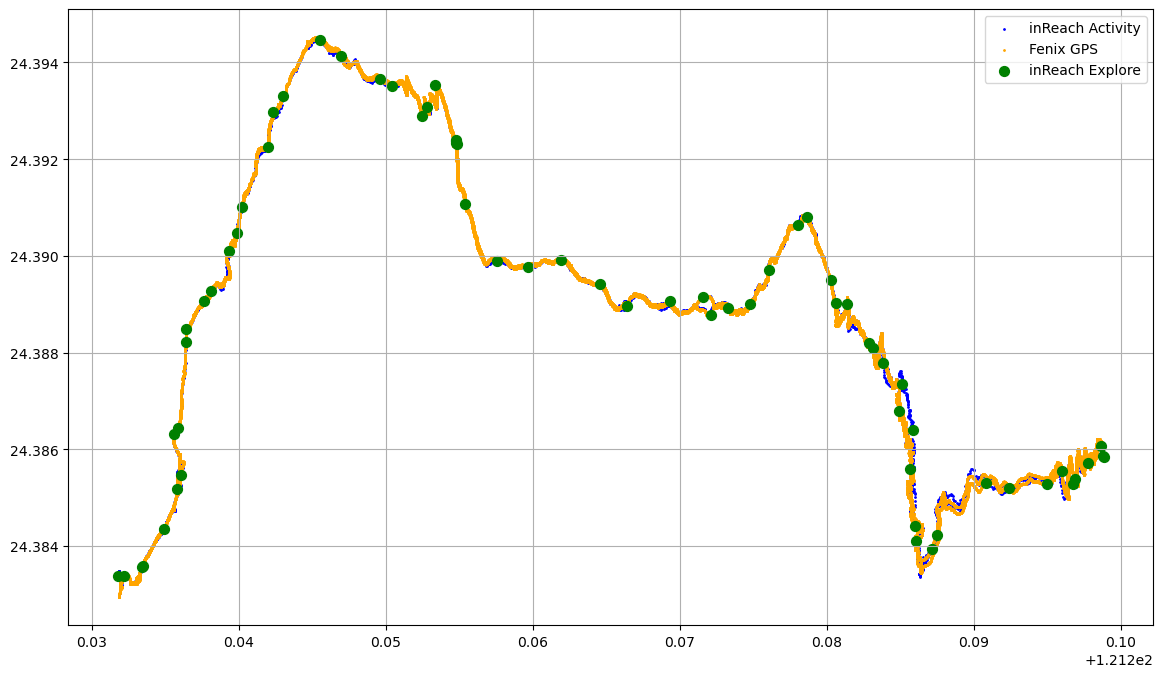

In [23]:
plt.scatter(df_in.lon, df_in.lat, color='blue', s=1, label="inReach Activity")
plt.scatter(df_fe.lon, df_fe.lat, color='orange' , s=1, label="Fenix GPS")
plt.scatter(df_ex.lon, df_ex.lat, color='green' , s=50, label="inReach Explore")

plt.grid()
plt.legend()
plt.show()

## 圖8 經緯度登頂區間比較

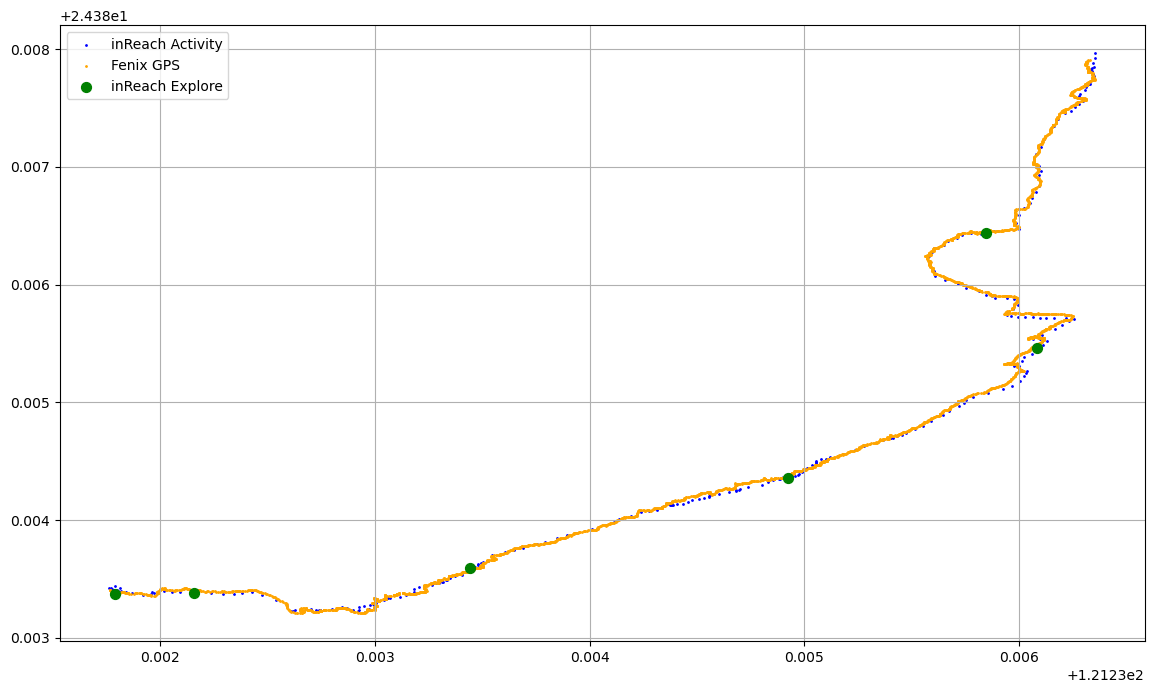

In [24]:
plt.scatter(df_in_zoom.lon, df_in_zoom.lat, color='blue', s=1, label="inReach Activity")
plt.scatter(df_fe_zoom.lon, df_fe_zoom.lat, color='orange' , s=1, label="Fenix GPS")
plt.scatter(df_ex_zoom.lon, df_ex_zoom.lat, color='green' , s=50, label="inReach Explore")

plt.grid()
plt.legend()
plt.show()

## 圖9 手癢畫個3D圖

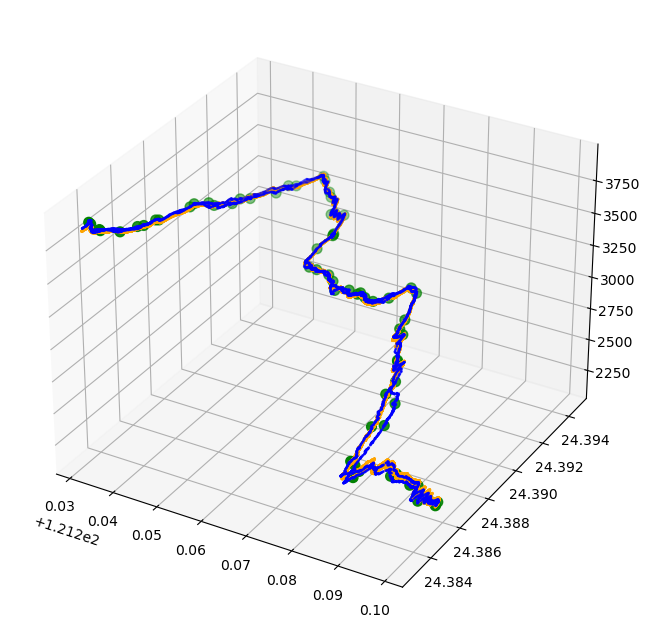

In [25]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(df_in.lon, df_in.lat, df_in.alt, color='blue', s=1, label="inReach Activity")
ax.scatter(df_fe.lon, df_fe.lat, df_fe.alt, color='orange' , s=1, label="Fenix GPS")
ax.scatter(df_ex.lon, df_ex.lat, df_ex.alt, color='green' , s=50, label="inReach Explore")

## 圖10 將inReach點位套上地圖觀察
> 本來想用魯地圖的, 不知道有沒有侵權問題, 還是先用OSM

這邊只畫上inReach 的兩種點位

In [26]:
import folium
#fmap = folium.Map(height=500, location=[24.38,121.28], zoom_start=14,tiles='http://xxxbasecamp.tw/{z}/{x}/{y}.png',attr='魯地圖@basecamp.tw')
fmap = folium.Map(height=500, location=[24.39,121.27], zoom_start=14,tiles='OpenStreetMap')

def plotDot(point,c,r):
    folium.CircleMarker(location=[point.lat, point.lon], fill=True, fill_opacity=1, radius=r, weight=2,color=c,popup=str(point.alt)+"m").add_to(fmap)

df_in.apply(plotDot,axis=1,args=("blue",1,))
#df_fe.apply(plotDot,axis=1,args=("orange",1,))
df_ex.apply(plotDot,axis=1,args=("green",5))

fmap

# 結論
## 個人見解

1. Garmin inReach Mini2的GPS定位在上山途中(七卡->哭坡)部份有較大的偏移, 推測與路線上的遮蔽有關, 但下山在這一段正常
1. 在無遮蔽路段Garmin inReach Mini2所記錄之點位尚稱蠻平順
1. DTM資料的獲取還不熟悉, 或許可以多拿其他機關的資料來嘗試. (Google API要錢啊...)
1. Garmin inReach Mini2的GPS定位資料, 雖與Garmin fenix 7x sapphire solar所得到的資料有些許差距, 個人認為此設備在空曠的山上無誇張的飄移
1. 本人非GIS專業, 未考量周到的部份望各位先進指教

## 免責
1. 本文件不替任何人、機關、團體背書
1. 本文件不為反駁任何人、機關、團體, 純粹為登山科技設備探討
1. 本人不當大師、不做女神、不是大神, 望各位先進批評指教